In [347]:
import pandas as pd
import re
import string
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import Button, HBox
import asyncio
import warnings
import sys

from scipy.optimize import curve_fit
#from sklearn.preprocessing import MinMaxScaler
from scipy import stats


warnings.filterwarnings("error")
WELLS = 384
PLATE_COLS = 24
PLATE_ROWS = 16

In [358]:
%matplotlib notebook
raw = pd.read_csv('./input/NSC_IV_ppm120_13.41.23 4wofi conV.csv', sep='\t', index_col = 0)

In [359]:
raw.head()

,Unnamed: 1,Sweep 001,Sweep 001.1,Sweep 001.2,Sweep 001.3,Sweep 001.4,Sweep 001.5,Sweep 002,Sweep 002.1,Sweep 002.2,...,Sweep 010.2,Sweep 010.3,Sweep 010.4,Sweep 010.5,Sweep 011,Sweep 011.1,Sweep 011.2,Sweep 011.3,Sweep 011.4,Sweep 011.5
Sweep Results,,,,,,,,,,,,,,,,,,,,,
Parameter,Valid QC,Compound Name,Seal Resistance,INa,IK,Itail,Sweep Voltage/Current,Compound Name,Seal Resistance,INa,...,INa,IK,Itail,Sweep Voltage/Current,Compound Name,Seal Resistance,INa,IK,Itail,Sweep Voltage/Current
Time of Sweep,NaN,4.1360,4.1360,4.1360,4.1360,4.1360,4.1360,14.1600,14.1600,14.1600,...,94.6500,94.6500,94.6500,94.6500,105.0180,105.0180,105.0180,105.0180,105.0180,105.0180
Sweep Voltage/Current,NaN,-8.000000E-2,-8.000000E-2,-8.000000E-2,-8.000000E-2,-8.000000E-2,-8.000000E-2,-6.500000E-2,-6.500000E-2,-6.500000E-2,...,5.500000E-2,5.500000E-2,5.500000E-2,5.500000E-2,7.000000E-2,7.000000E-2,7.000000E-2,7.000000E-2,7.000000E-2,7.000000E-2
A01,T,External,1.729283E+12,-1.666586E-11,1.666586E-11,-6.514838E-11,-8.000000E-2,SE,2.902980E+10,-1.515079E-11,...,3.333173E-11,9.393487E-11,5.605791E-11,5.500000E-2,FullBlock,2.426933E+10,4.696744E-11,9.544995E-11,5.302775E-11,7.000000E-2
B01,T,External,7.069247E+7,-1.515079E-11,4.696744E-11,3.075610E-10,-8.000000E-2,SE,6.982844E+7,2.121110E-11,...,2.227166E-10,9.848011E-10,3.711943E-10,5.500000E-2,FullBlock,7.322841E+7,3.181665E-10,1.252970E-9,4.090712E-10,7.000000E-2


In [360]:
index = raw.index
columns = raw.columns
row_names = list(string.ascii_uppercase[:PLATE_ROWS])

In [361]:
num_sweeps = 1
num_param = 0
bool_mask = []

temp = 0
for column in columns:
    if re.match(r"Sweep \d{3}\.\d", column):
        bool_mask.append(True)
        param = int(column.split(".")[-1])
        if param > temp:
            temp = param
            if num_sweeps == 1:
                num_param += 1
        else:
            temp = 0
            num_sweeps += 1
    else:
        bool_mask.append(False)

In [362]:
parameters = raw.iloc[0,2:2+num_param].tolist()
parameters

['Seal Resistance', 'INa', 'IK', 'Itail', 'Sweep Voltage/Current']

In [363]:
relevant_data = raw.loc['A01':, columns[bool_mask]]

In [364]:
relevant_data.head()

,Sweep 001.1,Sweep 001.2,Sweep 001.3,Sweep 001.4,Sweep 001.5,Sweep 002.1,Sweep 002.2,Sweep 002.3,Sweep 002.4,Sweep 002.5,...,Sweep 010.1,Sweep 010.2,Sweep 010.3,Sweep 010.4,Sweep 010.5,Sweep 011.1,Sweep 011.2,Sweep 011.3,Sweep 011.4,Sweep 011.5
Sweep Results,,,,,,,,,,,,,,,,,,,,,
A01,1.729283E+12,-1.666586E-11,1.666586E-11,-6.514838E-11,-8.000000E-2,2.902980E+10,-1.515079E-11,1.666586E-11,6.969362E-11,-6.500000E-2,...,5.491129E+10,3.333173E-11,9.393487E-11,5.605791E-11,5.500000E-2,2.426933E+10,4.696744E-11,9.544995E-11,5.302775E-11,7.000000E-2
B01,7.069247E+7,-1.515079E-11,4.696744E-11,3.075610E-10,-8.000000E-2,6.982844E+7,2.121110E-11,8.635948E-11,3.393776E-10,-6.500000E-2,...,7.172818E+7,2.227166E-10,9.848011E-10,3.711943E-10,5.500000E-2,7.322841E+7,3.181665E-10,1.252970E-9,4.090712E-10,7.000000E-2
C01,1.389680E+9,0.000000E+0,3.333173E-11,-2.866529E-9,-8.000000E-2,1.335870E+9,-3.333173E-11,3.181665E-11,-2.640782E-9,-6.500000E-2,...,1.281425E+9,-2.499880E-10,8.787456E-11,-3.181665E-11,5.500000E-2,1.408498E+9,-3.484681E-11,1.227214E-10,8.938964E-11,7.000000E-2
D01,1.442500E+8,4.696744E-11,7.878409E-11,7.120870E-11,-8.000000E-2,1.420884E+8,3.939205E-11,7.423885E-11,7.120870E-11,-6.500000E-2,...,1.392561E+8,-9.696503E-11,9.696503E-11,8.484440E-11,5.500000E-2,1.336749E+8,-2.121110E-10,1.166611E-10,1.045404E-10,7.000000E-2
E01,1.563194E+9,-3.181665E-11,1.818094E-11,-2.381704E-9,-8.000000E-2,1.485319E+9,-2.424126E-11,1.818094E-11,-2.018085E-9,-6.500000E-2,...,1.481644E+9,-4.802799E-10,1.621134E-10,1.454475E-10,5.500000E-2,1.201100E+9,-7.181473E-10,2.378673E-10,2.878650E-10,7.000000E-2


In [365]:
potentials = []
sodium_sweeps = []

for index, param in enumerate(parameters):
    param = param.replace("/", "Per")
    
    if param == "Sweep VoltagePerCurrent":
        for sweep in range(1, num_sweeps+1):
            col = num_param*(sweep-1) + index
            potentials.append(float(relevant_data.iloc[2,col]) * 1000)
            
    if param == "INa":
        for sweep in range(1, num_sweeps+1):
            col = num_param*(sweep-1) + (index)
            sodium_arr = relevant_data.iloc[:,col].astype(float).to_numpy()
            sodium_arr = sodium_arr.reshape(
                PLATE_ROWS, PLATE_COLS, order='F')
            clean_sweep = pd.DataFrame(data = sodium_arr, index=row_names, columns=range(1,PLATE_COLS+1))
            sodium_sweeps.append(clean_sweep * 10**12)
            

In [366]:
sodium_sweeps[0].head()

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
A,-16.66586,-51.51267,-30.30157,-25.756340,-65.14838,-34.84681,-133.326900,-10.60555,-27.27142,7.575393,...,-13.63571,-18.18094,-18.180940,72.72377,-37.87697,-22.72618,54.54283,-31.81665,-18.18094,-10.60555
B,-15.15079,-19.69602,90.90472,-24.241260,-24.24126,-15.15079,-33.331730,-33.33173,-18.18094,-12.120630,...,-48.48252,-21.21110,9.090471,56.05791,-40.90712,-18.18094,-22.72618,-31.81665,-40.90712,-15.15079
C,0.00000,-27.27142,-103.02530,-69.693620,-18.18094,-12.12063,-31.816650,-74.23885,-16.66586,-15.150790,...,-42.42220,-16.66586,-16.665860,-36.36189,-16.66586,-19.69602,-37.87697,-18.18094,-31.81665,-15.15079
D,46.96744,-27.27142,-86.35948,-9.090471,-92.41979,-18.18094,-24.241260,-16.66586,-18.18094,-15.150790,...,-16.66586,69.69362,-22.726180,-10.60555,-21.21110,-19.69602,56.05791,-24.24126,-63.63330,-30.30157
E,-31.81665,-30.30157,-10.60555,-13.635710,-30.30157,-19.69602,-4.545236,-19.69602,-31.81665,-12.120630,...,-25.75634,-15.15079,-24.241260,-12.12063,-16.66586,-28.78649,-48.48252,-13.63571,-21.21110,-42.42220


In [367]:
def func_IV_NA(v, vrev, gmax, vhalf, vslope): # IV
    return (v - vrev) * gmax/(1 + np.exp((vhalf - v)/vslope))

def wait_for_choice(accept, reject, quit):
    future = asyncio.Future()
    def getvalue(change):
        future.set_result(change.description)
        accept.on_click(getvalue, remove=True)
        reject.on_click(getvalue, remove=True)
        quit.on_click(getvalue, remove=True)  
        # we need to free up the binding to getvalue to avoid an InvalidState error
        # buttons don't support unobserve
        # so use `remove=True` 
    accept.on_click(getvalue)
    reject.on_click(getvalue)
    quit.on_click(getvalue)
    return future

def get_statistics(frame):
    index = 0
    for label, content in frame.items():
        if(label == "Cell"):
            continue
        
        statistics.iloc[index]["Variable"] = label
        statistics.iloc[index]["Mean"] = np.mean(content)
        statistics.iloc[index]["Median"] = np.median(content)
        statistics.iloc[index]["Std. Dev"] = np.std(content, ddof=1)
        statistics.iloc[index]["Std. Err"] = stats.sem(content, axis=None, nan_policy="omit")
        statistics.iloc[index]["Max"] = np.max(content)
        statistics.iloc[index]["Min"] = np.min(content)
        statistics.iloc[index]["N"] = np.sum(content.count())
        index += 1
        
    return statistics

<IPython.core.display.Javascript object>


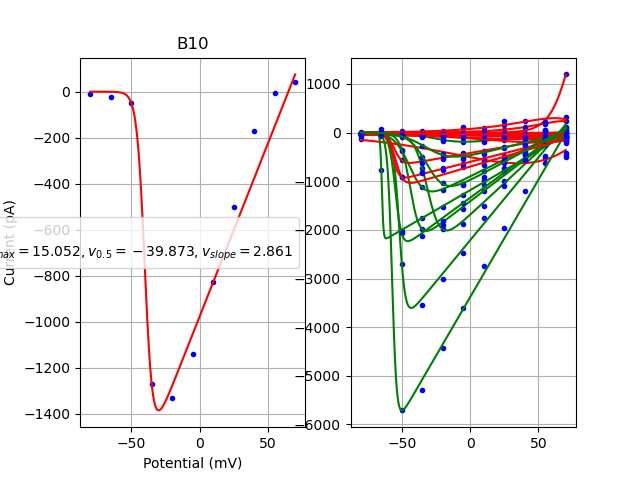

Fit failed for A09
Unexpected error: <class 'RuntimeWarning'>
Fit failed for A14
Unexpected error: <class 'RuntimeWarning'>
Fit failed for A21
Unexpected error: <class 'RuntimeWarning'>


In [368]:
async def draw_graphs():

    fig = plt.figure()
    ax = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax2.grid()
    plt.ion()

    fig.show()
    fig.canvas.draw()
    
    index = 1
    write_col = 1
    done = False
    for row in range(0, PLATE_ROWS):
        for col in range(0, PLATE_COLS):
            ydata = []
            title = row_names[row] + "{:02d}".format(col + 1)
            for sweep in sodium_sweeps:
                ydata.append(sweep.iloc[row,col])
            
            try:
                bounds = ((65,-np.inf,-np.inf,-np.inf),(85,np.inf,np.inf,np.inf))
                popt, pcov = curve_fit(func_IV_NA, potentials, ydata, p0=[70,0.4,0.6,1], bounds=bounds, maxfev=100000)
            except:
                print("Fit failed for " + title)
                failed.loc[0 if pd.isnull(failed.index.max()) else failed.index.max() + 1] = title
                continue
        
            label = 'fit: $v_{rev}=%5.3f, g_{max}=%5.3f, v_{0.5}=%5.3f, v_{slope}=%5.3f$' % tuple(popt)
            ax.clear()
            ax.plot(potentials, ydata, 'b.', label="data")
            xrange = np.arange(min(potentials), max(potentials), 0.01)
            ax.plot(xrange, func_IV_NA(xrange, *popt), 'r-', label=label)
            ax.grid()
            ax.legend()
        
            ax.set_title(title)
            ax.set_xlabel("Potential (mV)")
            ax.set_ylabel("Current (pA)")
            
            
            
            fig.canvas.draw()
            choice = await wait_for_choice(accept, reject, quit)
            
            if(choice == "Accept"):
                accepted_fits.loc[index,'Cell'] = title
                accepted_fits.loc[index,'v_rev':'v_slope'] = popt
                index += 1
                
                ax2.plot(potentials, ydata, 'b.', label="data")
                ax2.plot(xrange, func_IV_NA(xrange, *popt), 'g-', label=label)
                
                source[title] = ydata
            elif(choice == "Reject"):
                ax2.plot(potentials, ydata, 'b.', label="data")
                ax2.plot(xrange, func_IV_NA(xrange, *popt), 'r-', label=label)
            elif(choice == "Quit"):
                done = True
                break
                
        if done:
            break
                
    accepted_fits.set_index('Cell')
    
    statistics = get_statistics(accepted_fits)
            
accept = Button(description="Accept")
reject = Button(description="Reject")
quit = Button(description="Quit")
accepted_fits = pd.DataFrame(columns=["Cell","v_rev","g_max","v_half","v_slope"])
failed = pd.DataFrame(columns = ["Failed"])
statistics = pd.DataFrame(index=np.arange(0,accepted_fits.shape[1]-1), columns=["Variable","Mean","Median","Std. Dev","Std. Err","Max","Min","N"])
source = pd.DataFrame(potentials, columns=["Potential"])
asyncio.create_task(draw_graphs())
HBox([accept, reject, quit])

In [369]:
################## WRITE TO EXCEL
with pd.ExcelWriter('test.xlsx') as writer: 
    name = "Result"
    workbook = writer.book
    worksheet = workbook.add_worksheet(name)
    writer.sheets[name] = worksheet
    accepted_fits.to_excel(writer,sheet_name=name,startrow=0 , startcol=0)
    statistics.to_excel(writer,sheet_name=name,startrow=0, startcol=accepted_fits.shape[1]+2)
    failed.to_excel(writer,sheet_name=name, startrow = statistics.shape[0]+2, startcol = accepted_fits.shape[1]+2)
    
    source_sheet = workbook.add_worksheet('source')
    writer.sheets['source'] = source_sheet
    source.to_excel(writer, sheet_name='source', startrow = 0, startcol=0)